# Social Media Analytics - Project

In [0]:
#Packages to install
!pip install emot
!pip install stats
!sudo apt-get install graphviz
!pip install python-igraph

In [2]:
%matplotlib inline
from operator import itemgetter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import math
import tweepy
import ast
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from collections import Counter, defaultdict 
import json
import numbers
import re
import os.path
import datetime
from tweepy import OAuthHandler, Stream, StreamListener
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
import igraph as ig
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.approximation.dominating_set import min_weighted_dominating_set, min_edge_dominating_set
import community
import matplotlib.cm as cm
import stats

pd.options.display.max_colwidth = 400
pd.options.display.max_rows = 25
pd.options.display.max_columns = None

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Load database
db = pd.read_csv("/content/QAnonRidotto.csv")
db.drop("Unnamed: 0",axis=1,inplace=True)
db.head(1)

id           User  \
0  1268545440913424385  Amynicole1005   

                                                                                                                                    original_text  \
0  RT @M2Madness: The MSM wants you to forget about them saying this before the riots started...\n\nEnemy of the People... #QAnon H/t Anon https…   

    hashtags       mentions  Follower  Following retweeted_user quoted_user  \
0  ['QAnon']  ['M2Madness']       616        872      M2Madness         NaN   

  replied_user  \
0          NaN   

                                                                                                             text  \
0  the msm wants you to forget about them saying this before the riots started enemy of the people qanon h t anon   

   IsBot  
0      0

## Tweets collection
[_](https://github.com/lorenzofamiglini/Social-Media-Analytics/blob/master/Progetto_Social_Media_tweepy_stream.ipynb)

[TweetObject doc.](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)

Tweets have been collected in the 24 hours after George Floyd's funeral, indirectly acting as a catalyst event.

In [0]:
#Authentication (https://developer.twitter.com/en/apps/16155617)
secret = pd.read_csv("/Users/riccardocervero/Desktop/DataScience/Materie/Social Media Analytics/secret.csv",header=None)
consumer_key = secret.loc[0][1]
consumer_key_secret = secret.loc[1][1]
access_token = secret.loc[2][1]
access_token_secret = secret.loc[3][1]
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [0]:
num_max = 50000
file = "/Users/riccardocervero/Desktop/DataScience/Materie/Social Media Analytics/QAnonTweet.txt"

class StdOutListener(StreamListener):
    ''' Handles data received from the stream. '''
    
    def __init__(self, api=None):
        super(StdOutListener, self).__init__()
        self.count = 37797
        self.file = open(file, "a")
 
    def on_status(self, status):
        tweet = json.dumps(status._json)
        self.file.write(tweet + '\n')
        self.count += 1
        if self.count <= num_max:
            print(f'{self.count}\r', end="")
            return True
        else:
            return False
            self.file.close()
 
    def on_error(self, status_code):
        print(status_code)
        attempts = 0
        if status_code in [420, 500, 502, 503, 504]:
            attempts = attempts + 1
            time.sleep(450)
            print("Timeout in seconds: ", attempts * 1800)
            return False
        
        
text_query = ["WWG1WGA", "QAnon", "qanon", "qAnon","WhereWeGoOneWeGoAll","wherewegoonewegoall",
             "WWG1WGA_WORLDWIDE","WWG1WGAWORLDWIDE","GreatAwakening","GreatAwakeningWorldwide",
              "TheGreatAwakeningWorldwide","QArmy","QAnonusa", "qanonusa", "qAnonusa","QAnonUSA", "qanonUSA", "qAnonUSA",
              "QAnonUsa", "qanonUsa", "qAnonUsa","QSees","Qknows","QKNOWS","QSEES","QanonEurope",
              "QAnonEurope","qanoneurope"]
hashtag_query = ["#" + s for s in text_query]
search_query = list(set(text_query) | set(hashtag_query))
stream = tweepy.Stream(auth=api.auth, listener=StdOutListener(), tweet_mode='extended')

In [0]:
while True:
    try:
        stream.filter(track=[i for i in search_query],languages=["en"])
    except BaseException:
        print("An exception occured!")
        continue

In [0]:
l = []
def tweet_to_dataframe(file):
    with open(file, "r") as tweets_file:
        for line in tweets_file:
            t = json.loads(line)
            l.append(t)
    return pd.DataFrame(l)

db = tweet_to_dataframe(file)

In [0]:
#Export
db.to_csv("/content/QAnonRidotto.csv")

## Pre-processing

In [0]:
print("Observation: ",len(db))
print("Number of columns: ",len(db.columns))

Observation:  50007
Number of columns:  37


In [0]:
#Check if there are costant columns 
def costant(db):
    c = []
    for col in db.columns:
        if len(db[col].unique())==1:
            print(col,":",db[col].unique())
            c.append(col)
    return c

to_remove = costant(db)

contributors : [nan]
favorite_count : [0]
favorited : [False]
filter_level : ['low']
lang : ['en']
quote_count : [0]
reply_count : [0]
retweet_count : [0]
retweeted : [False]


In [0]:
db.drop([k for k in to_remove],axis=1,inplace=True)
len(db.columns)

28

In [0]:
#Check "coordinates" values
print([e for e in db.coordinates.unique()])
print(len(db[db.coordinates=="{'type': 'Point', 'coordinates': [-74.0064, 40.7142]}"]))
print(len(db[db.coordinates=="{'type': 'Point', 'coordinates': [-111.4926835, 33.1030516]}"]))

[nan, "{'type': 'Point', 'coordinates': [-74.0064, 40.7142]}", "{'type': 'Point', 'coordinates': [-111.4926835, 33.1030516]}"]
1
1


In [0]:
db.drop("coordinates",axis=1,inplace=True)
db.drop("geo",axis=1,inplace=True)
len(db.columns)

26

In [0]:
#Check "withheld_in_countries"
print([e for e in db.withheld_in_countries.unique()])
print(len(db[db.withheld_in_countries=="['DE']"])/len(db))

[nan, "['DE']"]
0.0009198712180294758


In [0]:
db.drop("withheld_in_countries",axis=1,inplace=True)
len(db.columns)

25

In [0]:
#Check "possibly_sensitive"
print([e for e in db.possibly_sensitive.unique()])
print(len(db[db.possibly_sensitive.isna()])/len(db))
print(len(db[db.possibly_sensitive==False])/len(db))
print(len(db[db.possibly_sensitive==True])/len(db))

[nan, False, True]
0.6641270222168897
0.3269342292079109
0.008938748575199471


In [0]:
db.drop("possibly_sensitive",axis=1,inplace=True)
len(db.columns)

24

In [0]:
#Remove othe useless variable
to_remove = ["quoted_status_permalink","timestamp_ms","display_text_range","id_str",
           "in_reply_to_status_id_str","in_reply_to_user_id_str","quoted_status_id_str",
          "in_reply_to_user_id","extended_entities","source"
            "created_at" #We don't have most of time zone values
            ]

db.drop([k for k in to_remove],axis=1,inplace=True)
len(db.columns)

13

In [0]:
#Check "place"
print(len(db.place.unique()))
print("% not null place values:",len(db[pd.notna(db.place)])/len(db))

75
% not null place values: 0.002679624852520647


In [0]:
db.drop("place",axis=1,inplace=True)
len(db.columns)

12


In [0]:
#Check % of "quoted" and retweet
print("% Quoted Tweet:",len(db[db.is_quote_status==True])/len(db))
print("% Retweeted Tweet:",1-len(db[db.retweeted_status.isna()])/len(db))
print("Number of tweet both quoted and retweet:",len(db[(db.is_quote_status==True) & (pd.notna(db.retweeted_status))]))
print("% Replies to Tweet:",len(db[pd.notna(db.in_reply_to_status_id)])/len(db))

% Quoted Tweet: 0.25558421820945065
% Retweeted Tweet: 0.7617733517307577
Number of tweet both quoted and retweet: 8804
% Replies to Tweet: 0.08442818005479233


In [0]:
db.drop("is_quote_status",axis=1,inplace=True)

### Full Text 

In [0]:
#Substitute "extend_tweet" with "text"
print(len(db[db.truncated==True]))
print(len(db[pd.notna(db.extended_tweet)]))
db.drop("truncated",axis=1,inplace=True)

6370
6370


In [0]:
def full_text(x):
    x = ast.literal_eval(x)
    return(x["full_text"])

print(db.loc[2]['text'],"\n")
print(full_text(db.loc[2]['extended_tweet']))

Notice the framing: you are either a believer or not a believer; there is an "authority model" of truth sources, pi… https://t.co/xR6CERfCS4 

Notice the framing: you are either a believer or not a believer; there is an "authority model" of truth sources, pick your external authority. Thinking for yourself is not an option to be considered. Indeed, it is implicitly derided as "backtracking" here. https://t.co/9eeRmQA1DK


In [0]:
t = []
for i in range(len(db)):
    if pd.notna(db.loc[i]["extended_tweet"]):
        t.append(full_text(db.loc[i]["extended_tweet"]))
    else:
        t.append(db.loc[i]['text'])

In [0]:
db.text = t
print(db.loc[2]['text'],"\n")
print(full_text(db.loc[2]['extended_tweet']))

Notice the framing: you are either a believer or not a believer; there is an "authority model" of truth sources, pick your external authority. Thinking for yourself is not an option to be considered. Indeed, it is implicitly derided as "backtracking" here. https://t.co/9eeRmQA1DK 

Notice the framing: you are either a believer or not a believer; there is an "authority model" of truth sources, pick your external authority. Thinking for yourself is not an option to be considered. Indeed, it is implicitly derided as "backtracking" here. https://t.co/9eeRmQA1DK


In [0]:
db.drop("extended_tweet",axis=1,inplace=True)
len(db.columns)

9

### Entities

Entities values are a set of:
- Hashtags
- URLs
- Mentions
- Symbols

In [0]:
db.loc[5]['entities']

"{'hashtags': [{'text': 'OBAMAGATE', 'indices': [20, 30]}, {'text': 'QANON', 'indices': [119, 125]}, {'text': 'WWG1WGA', 'indices': [126, 134]}], 'urls': [], 'user_mentions': [{'screen_name': 'ThanQTrump', 'name': 'Facts over Feelings', 'id': 935571037441445888, 'id_str': '935571037441445888', 'indices': [3, 14]}], 'symbols': []}"

#### Hashtags

In [0]:
def extract_hashtags(x):
    x = ast.literal_eval(x)
    a = x['hashtags']
    return [a[i]['text'] for i in range(len(a))]

extract_hashtags(db.loc[5]['entities'])

['OBAMAGATE', 'QANON', 'WWG1WGA']

In [0]:
h = []
for i in range(len(db)):
    h.append(extract_hashtags(db.loc[i]['entities']))
db['hashtags'] = h

#### Hashtags Analysis

In [0]:
hlist = [j for i in db.hashtags for j in i]
#Normalize
hlist = [e.lower() for e in hlist]
hdb = pd.DataFrame.from_dict(dict(Counter(hlist)), orient='index',columns=['Freq'])
hdb = hdb.sort_values('Freq',ascending=False)
hdb.reset_index(inplace=True)
hdb.columns = ['Hashtag','Freq']
#Top 20
hdb.iloc[0:20]

Hashtag   Freq
0               qanon  15534
1             wwg1wga   8534
2            fakenews   2352
3     wearethenewsnow   1364
4      greatawakening   1353
5           obamagate   1229
6    wwg1wgaworldwide   1087
7   thegreatawakening   1053
8         factsmatter    919
9       wakeupamerica    806
10               maga    732
11                  q    668
12              qarmy    611
13   blacklivesmatter    589
14          trump2020    478
15        coronavirus    378
16       exposeantifa    348
17             qanons    335
18             antifa    318
19            godwins    302

Text(0.5, 1.0, 'Top 25 Hashtags')

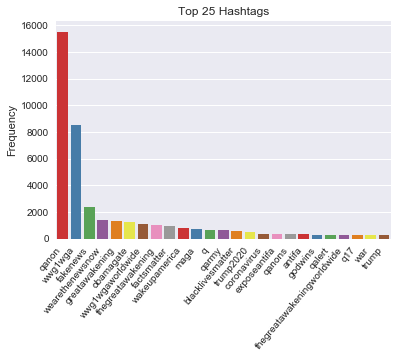

In [0]:
#Plot
hdb_ = hdb.iloc[0:25]
sns.set(style="darkgrid")
hplot = sns.barplot(x="Hashtag", y="Freq", data=hdb_,palette="Set1")
plt.xticks(
    rotation=50, 
    horizontalalignment='right'  
)
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Top 25 Hashtags")

Text(0.5, 1.0, 'Hashtags LogFrequency')

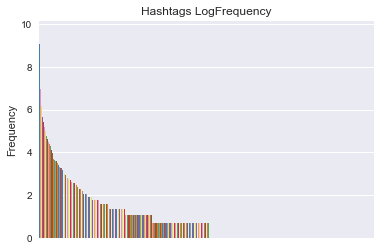

In [0]:
#LogDistrobution
sns.barplot(x="Hashtag", y=np.log(hdb.Freq), data=hdb,palette="Set1")
plt.xticks([], [])
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Hashtags LogFrequency")

#### Mentions

In [0]:
def extract_mentions(x):
    x = ast.literal_eval(x)
    b = x['user_mentions']
    return [b[i]['screen_name'] for i in range(len(b))]

extract_mentions(db.loc[20000]['entities'])

['girlsreallyrule', 'TheJusticeDept']

In [0]:
m = []
for i in range(len(db)):
    m.append(extract_mentions(db.loc[i]['entities']))
db['mentions'] = m

#### Mentions Analysis

In [0]:
mlist = [j for i in db.mentions for j in i]
mdb = pd.DataFrame.from_dict(dict(Counter(mlist)), orient='index',columns=['Freq'])
mdb = mdb.sort_values('Freq',ascending=False)
mdb.reset_index(inplace=True)
mdb.columns = ['Mention','Freq']
#Top 20
mdb.iloc[0:20]

Mention  Freq
0       honest2gosh  2760
1           cjtruth  2291
2        JuliansRum  2108
3   realDonaldTrump  1969
4         M2Madness  1887
5     Inevitable_ET  1696
6           Qanon76  1341
7     SheepKnowMore  1096
8           EyesOnQ   933
9      PayRespectsF   927
10       Yoder_Esqq   910
11    IndySpanglish   876
12            POTUS   860
13    intheMatrixxx   840
14  stormypatriot21   719
15      georgesoros   677
16         pappyG45   640
17          thehill   562
18          Wyn1745   551
19         wmalnews   534

Text(0.5, 1.0, 'Top 25 Mentions')

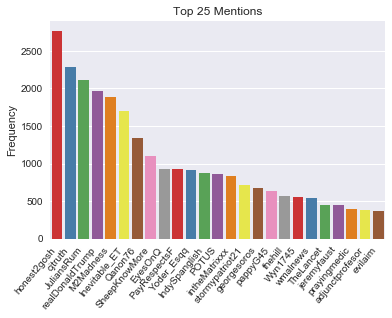

In [0]:
#Plot
mdb_ = mdb.iloc[0:25]
sns.barplot(x="Mention", y="Freq", data=mdb_,palette="Set1")
plt.xticks(
    rotation=50, 
    horizontalalignment='right'  
)
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Top 25 Mentions")

Text(0.5, 1.0, 'Mentions LogFrequency')

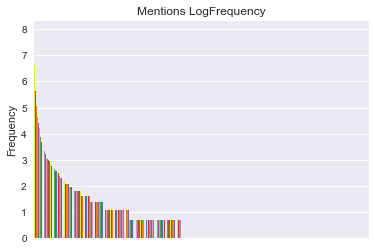

In [0]:
#LogDistrobution
sns.barplot(x="Mention", y=np.log(mdb.Freq), data=mdb,palette="Set1")
plt.xticks([], [])
plt.xlabel("")
plt.ylabel("Frequency")
plt.title("Mentions LogFrequency")

In [0]:
db.drop("entities",axis=1,inplace=True)
len(db.columns)

10

### Retweet

In [0]:
def extract_user_retweeted(x):
    x = ast.literal_eval(x)
    return x['user']['screen_name']

extract_user_retweeted(db.loc[0]["retweeted_status"])

'M2Madness'

In [0]:
r = []
for i in range(len(db)):
    if pd.notna(db.loc[i]['retweeted_status']):
        r.append(extract_user_retweeted(db.loc[i]['retweeted_status']))
    else:
        r.append(np.nan)
db['retweeted_user'] = r

In [0]:
db.drop("retweeted_status",axis=1,inplace=True)
len(db.columns)

10

### Quotes

In [0]:
def extract_user_quoted(x):
    x = ast.literal_eval(x)
    return x['user']['screen_name']

extract_user_quoted(db.loc[16]["quoted_status"])

'ThanQTrump'

In [0]:
q = []
for i in range(len(db)):
    if pd.notna(db.loc[i]['quoted_status']):
        q.append(extract_user_quoted(db.loc[i]['quoted_status']))
    else:
        q.append(np.nan)
db['quoted_user'] = q

In [0]:
db.drop(["quoted_status","quoted_status_id"],axis=1,inplace=True)
len(db.columns)

9

### Replies

In [0]:
db.drop(["in_reply_to_status_id"],axis=1,inplace=True)
db.rename(columns={'in_reply_to_screen_name':'replied_user'}, inplace=True)

### User

Interesting user's attributes are:
- screen_name (unique name)
- followers_count (followers)
- friends_count (following)

In [0]:
def get_data(x,d):
    x = ast.literal_eval(x)
    if d=="screen_name":
        return x['screen_name']
    elif d=="follower":
        return x['followers_count']
    elif d=="following":
        return x['friends_count']


print("Screen name:",get_data(db.loc[0]['user'],"screen_name"))
print("Number of follower:",get_data(db.loc[0]['user'],"follower"))
print("Number of following:",get_data(db.loc[0]['user'],"following"))

Screen name: Amynicole1005
Number of follower: 616
Number of following: 872


In [0]:
s = []
er = []
ing = []
for i in range(len(db)):
    s.append(get_data(db.loc[i]['user'],"screen_name"))
    er.append(get_data(db.loc[i]['user'],"follower"))
    ing.append(get_data(db.loc[i]['user'],"following"))
    
db['User'] = s
db['Follower'] = er
db['Following'] = ing

db.drop(["user"],axis=1,inplace=True)

In [0]:
db = db[['id','User','text','hashtags','mentions','Follower','Following','retweeted_user',
        'quoted_user','replied_user']]
db.head(1)

#### Users Analysis

In [0]:
print("Number of users: ",len(db.User.unique()))
print("Number of mentioned user: ",len(db.mentions.unique()))
print("Number of user replied to: ",len(db.replied_user.unique()))
print("Number of quoted user: ",len(db.quoted_user.unique()))
total = set(db.User.unique())|set(mlist)|set(db.replied_user.unique())|set(db.quoted_user.unique())
print("Total number of users: ",len(total))
#Create interaction list
u_count = dict(Counter([i for i in db.User if pd.notna(i)]))
r_count = dict(Counter([i for i in db.replied_user if pd.notna(i)]))
q_count = dict(Counter([i for i in db.quoted_user if pd.notna(i)]))
m_count = [ast.literal_eval(i) for i in db.mentions]
m_count = dict(Counter([j for i in m_count for j in i]))
input=[u_count,r_count,q_count,m_count]
d = pd.DataFrame.from_dict(sum((Counter(dict(x)) for x in input),Counter()),orient="index",columns=['N. interactions'])
d.sort_values("N. interactions",ascending=False,inplace=True)
print("20 most interacting users:","\n")
display(d.iloc[0:20])

Number of users:  26770
Number of mentioned user:  6420
Number of user replied to:  2025
Number of quoted user:  1662
Total number of users:  28922
20 most interacting users: 



N. interactions
honest2gosh                 4007
cjtruth                     2681
realDonaldTrump             2492
JuliansRum                  2467
M2Madness                   2287
Inevitable_ET               1773
Yoder_Esqq                  1477
Qanon76                     1392
SheepKnowMore               1245
PayRespectsF                1220
ThanQTrump                  1160
stormypatriot21             1115
EyesOnQ                     1013
IndySpanglish                969
intheMatrixxx                952
thehill                      871
POTUS                        869
wmalnews                     748
jeremyfaust                  681
georgesoros                  680

In this top 20 most interacting/mentioned users we can see famous ones like:
- Donald Trump, as [personal account](https://twitter.com/realDonaldTrump) and [official account](https://twitter.com/POTUS)
- [George Soros](https://twitter.com/georgesoros)

### Duplicates

In [0]:
#Check full duplicates
to_check = set(db.columns)-set(['hashtags','mentions'])
print("Number of duplicates:",len(db[db.duplicated(subset=[k for k in to_check],keep='last')]))
db.drop_duplicates(subset=[k for k in to_check],keep='last',inplace=True)
len(db)

Number of duplicates: 275


49732

In [0]:
print("Number of id duplicates:",len(db[db.duplicated(subset=["id"],keep='last')]))

Number of id duplicates: 0


In [0]:
db.to_csv("/Users/riccardocervero/Desktop/QAnonRidotto.csv")

### Text Preprocessing

In [0]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have","yep":"yes","ty":"thank you","rt":"retweet"}


def rem(x):
    for p in [".",",","!","?"]:
        x = str(x).replace(p," ")
    return x


def convert_emo(text):
    #Emojis into word
    for emot in UNICODE_EMO:
        text = text.replace(emot, " ".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    #Emoticons into word
    for emot in EMOTICONS:
        text = re.sub(u'('+emot+')', " ".join(EMOTICONS[emot].replace(",","").split()), text)
    return text

def rem_contractions(x):
    x = rem(x).split()
    new_text = []
    for word in x:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    return ' '.join([str(elem) for elem in new_text])

def text_preprocessing(x,remove_stop_word=False):
    cleaned = re.sub(r'http\S+', '', x)
    #Convert hashtags into words
    re.sub(r'#',"",cleaned)
    #Remove mentions for retweet
    cleaned = re.sub(r'RT @([^\s:]+):',"",cleaned)
    #Remove other mentions
    cleaned = re.sub(r'@([^\s:]+)',"",cleaned)
    cleaned = "".join([i for i in [s.lower() for s in cleaned]])
    cleaned = rem_contractions(cleaned)
    cleaned = convert_emo(cleaned)
    cleaned = re.sub("[^a-zA-Z]", ' ', cleaned) # remove punctuation, special characters and numbers
    if remove_stop_word:
        cleaned = " ".join([i for i in word_tokenize(cleaned) if i not in stop_words])
    return ' '.join(cleaned.split())

In [0]:
print("ORIGINAL TEXT:",db.text[12],"\n")
print("PREPROCESSED TEXT:",text_preprocessing(db.text[12]))

ORIGINAL TEXT: RT @Pat_Potvin: RT to inform
#MockingbirdMedia #GreatAwakening #WWG1WGAWORLDWIDE 

@Pat_Potvin @PatPatriot55 

PREPROCESSED TEXT: retweet to inform mockingbirdmedia greatawakening wwg wgaworldwide


In [0]:
db.rename(columns={'text':'original_text'}, inplace=True)
db['text'] = db.original_text.apply(text_preprocessing)

In [0]:
#Check duplicated texts
print("Total number of duplicated texts:",len(db[db.duplicated(subset=["text"],keep='last')]))
print("Number of unique duplicated texts:",len(db[db.duplicated(subset=["text"],keep='last')]['text'].unique()))
print("Portion of duplicated text among unique texts:",str(100*len(db[db.duplicated(subset=["text"],keep='last')]['text'].unique())/len(db['text'].unique()))+"%")

Total number of duplicated texts: 35855
Number of unique duplicated texts: 2889
Portion of duplicated text among unique texts: 20.818620739352887%


In [0]:
db.to_csv("/Users/riccardocervero/Desktop/QAnonRidotto.csv")

## Is Bot?

In [0]:
#Read bot database extracted by twitterbot library from R
bot = pd.read_csv("/content/bot.csv")
bot.drop("Unnamed: 0",axis=1,inplace=True)
bots = [e for e in bot[bot.prob_bot>=0.85]['screen_name']]
print("Number of bots:",len(bots))

Number of bots: 387


In [0]:
isbot = []
for u in db.User:
  if u in bots:
    isbot.append("1")
  else:
    isbot.append("0")
db['IsBot'] = isbot

In [0]:
print("Number of tweets by bot:",len(db[db.IsBot=="1"]))
print("Top 20 bot:","\n")
display(bot.loc[0:20][['screen_name','prob_bot']])

Number of tweets by bot: 840
Top 20 bot: 



screen_name  prob_bot
0      Holmesdonna1  0.999726
1           Culmum1  0.998895
2            Nvania  0.998879
3           amars50  0.997957
4      Lonewolf2716  0.997685
5       angelataboo  0.997093
6         Smiler191  0.997069
7       jcpretorius  0.996966
8      AsilanaQAnon  0.996562
9      tachyonluxor  0.996129
10   keppler_brenda  0.995840
11     singingval61  0.995725
12        grace9556  0.995273
13   tucsonfirebird  0.994679
14    MexicanoQanon  0.994560
15  KatWoma67811984  0.993839
16     TommyJonson7  0.993643
17        IvyBlood2  0.993293
18        haigh_ken  0.992945
19      Victoriel44  0.992854
20    Superdad20001  0.992021

______________________________________________________________________________________________________________________


## **Interaction graph**

[_](https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb)

In [0]:
#Save big graph
#nx.write_gpickle(g,"/content/BigGraph.gpickle")
#Load big graph
g = nx.read_gpickle("/content/ReducedGraph.gpickle")

In [0]:
#Function to extract interactions
def get_interactions(row):
    user = row["User"] 
    interactions = set() #Interactions are set of tuples
    #1)replies
    if pd.notna(row["replied_user"]):
      interactions.add((row["replied_user"],"r"))
    #2)retweets
    if pd.notna(row["retweeted_user"]):
      interactions.add((row["retweeted_user"],"g"))
    #3)quotes
    if pd.notna(row["quoted_user"]):
      interactions.add((row["quoted_user"],"b"))
    #3)mentions
    if pd.notna(row["mentions"]):
      for i in ast.literal_eval(row['mentions']):
        interactions.add((i,"orange"))
    # Discard auto-interactions
    interactions.discard((row["User"]))
    # Discard all not existing values
    interactions.discard((None, None))
    # Return user and interactions
    return user, interactions

#Function to draw interactions
def draw_interactions(db, plot = True, labels = False, prog="neato",filter=False,k=1):
  c = []
  botnode = []
  #Initialize graph
  graph = nx.Graph()
  #Build graph
  for index, tweet in db.iterrows():
    user, interactions = get_interactions(tweet)
    user_name = user
    tweet_id = tweet["id"]
    for interaction in interactions:
        int_name = interaction[0]
        c.append(interaction[1])
        graph.add_edge(user_name, int_name)
        graph.add_node(user_name)
        if user_name in bots:
          botnode.append(user_name)
        graph.add_node(int_name)
  print("Original graph has",graph.number_of_nodes(),"nodes and",graph.number_of_edges(),"edges.")
  if filter:
    to_del = [n for n in graph if graph.degree(n) <= k]
    graph.remove_nodes_from(to_del)
  #Find the biggest connected component
  largest_subgraph = max((graph.subgraph(c) for c in nx.connected_components(graph)), key=len)
  botnode = set([n for n in botnode if n in largest_subgraph])
  notbot = set([n for n in largest_subgraph if n not in botnode])
  #Get degree
  d = dict(graph.degree)
  dbot = {k: v for k, v in d.items() if k in botnode}
  dnotbot = {k: v for k, v in d.items() if k in notbot}
  if plot:
    #pos = nx.spring_layout(largest_subgraph,k=10) #Default layout
    pos = nx.nx_pydot.graphviz_layout(largest_subgraph,prog=prog)
    plt.figure(figsize = (35,35))
    nx.draw(largest_subgraph,pos=pos,alpha=0)
    nx.draw_networkx_nodes(largest_subgraph,pos=pos,nodelist=botnode,
                           #node_size=[np.log(v*1e5) for v in dbot.values()], #Size ~ Drgree
                           node_shape="s",node_color="red")
    nx.draw_networkx_nodes(largest_subgraph,pos=pos,nodelist=notbot
                           #node_size=[np.log(v*1e5) for v in dnotbot.values()]
                           )
    nx.draw_networkx_edges(largest_subgraph,pos=pos,width=0.3,edge_color = c)
    file_img = '/content/' + str(prog) + ".png"
    plt.savefig(file_img)
    plt.show()
  return(largest_subgraph)

In [0]:
#Progr type: "neato","dot","twopi","fdp","sfdp","circo"
g = draw_interactions(db,prog="circo")

In [0]:
print(f"There are {g.number_of_nodes()} nodes and {g.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in g.degree()]
print(f"The maximum degree of the graph is {np.max(degrees)}")   
print(f"The minimum degree of the graph is {np.min(degrees)}")
print(f"The average degree in the graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree in the graph is {stats.mode(degrees)}")
if nx.is_connected(g):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"The average clustering coefficient is {nx.average_clustering(g)} in this largest subgraph.")
print(f"The transitivity is {nx.transitivity(g)}.")
#print(f"The diameter of our Graph is {nx.diameter(g)}")
#print(f"The average distance between any two nodes is {nx.average_shortest_path_length(g):.2f}")

There are 29300 nodes and 63866 edges present in the graph
The maximum degree of the graph is 3317
The minimum degree of the graph is 1
The average degree in the graph is 4.4
The most frequent degree in the graph is 1
The graph is connected
The average clustering coefficient is 0.1531191780863585 in this largest subgraph.
The transitivity is 0.002590163477149871.


Then, most important nodes are filtered based on their degree.

Original graph has 30914 nodes and 65001 edges.


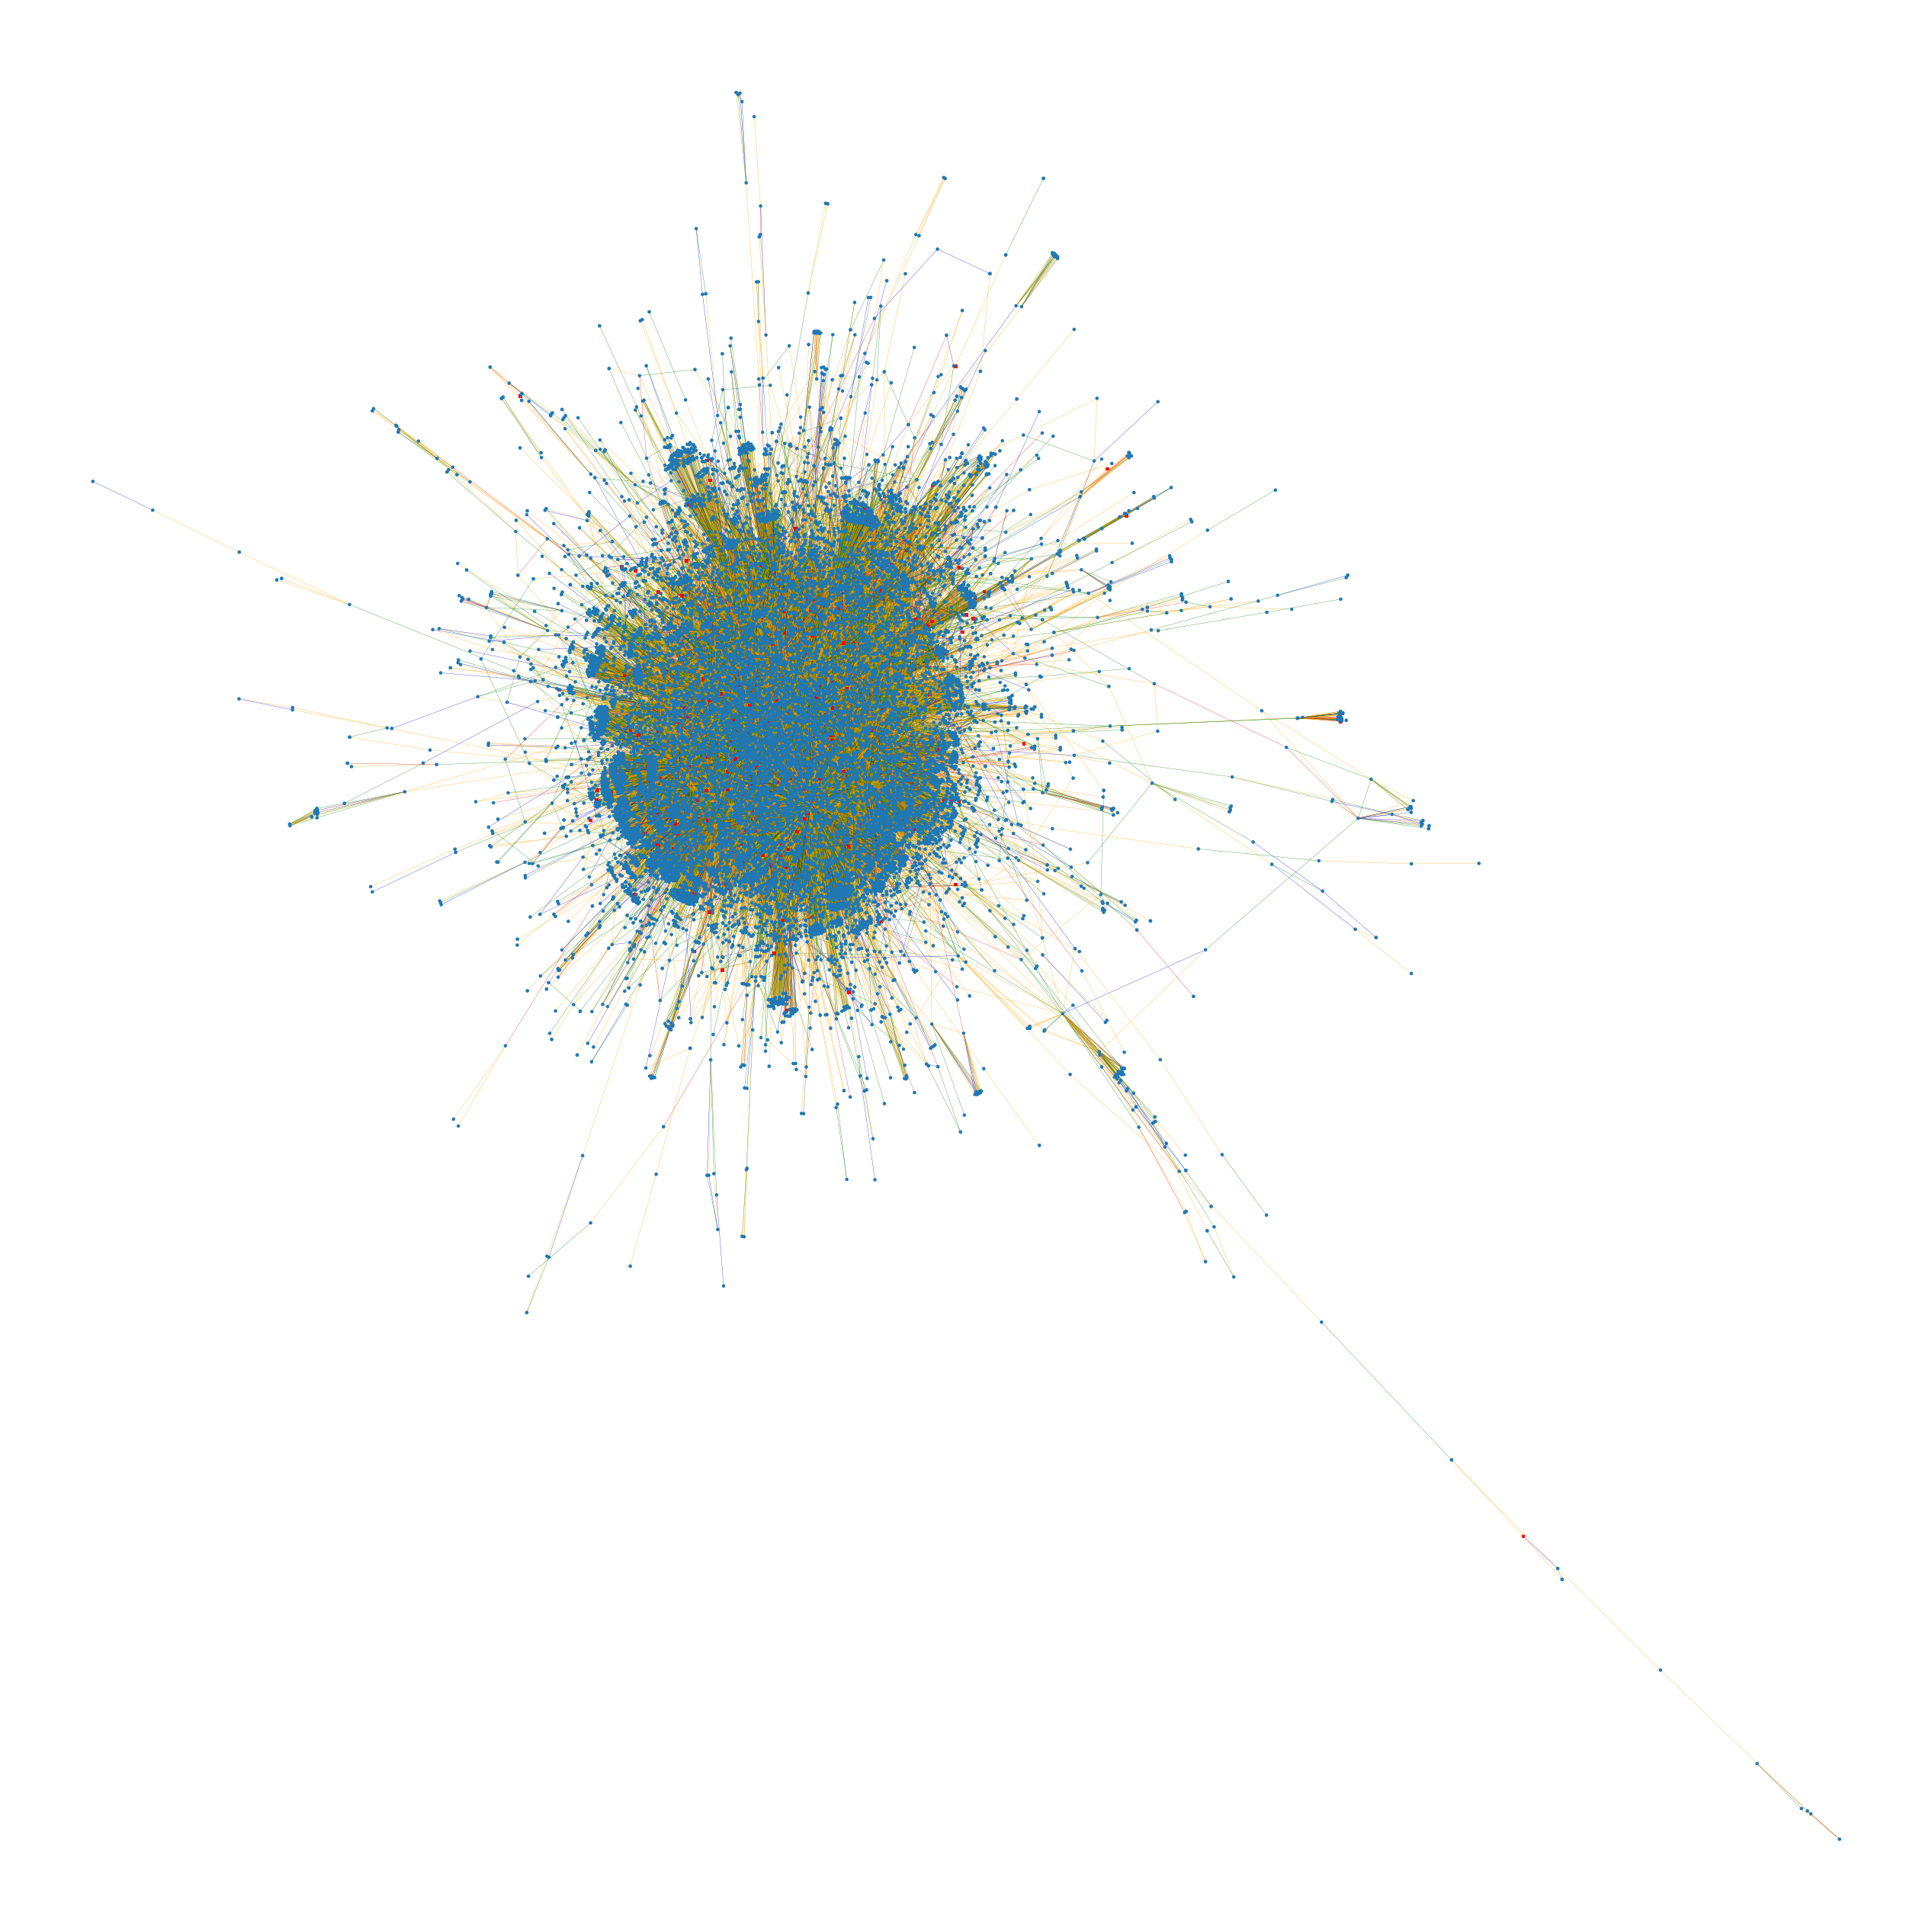

In [0]:
#Node with degree = 1 are removed
g1 = draw_interactions(db, prog="sfdp",filter=True,k=1)

## **Graph metrics**

In [0]:
#Basic metrics
print(f"There are {g1.number_of_nodes()} nodes and {g1.number_of_edges()} edges present in the Graph")
degrees = [val for (node, val) in g1.degree()]
print(f"The maximum degree of the graph is {np.max(degrees)}")   
print(f"The minimum degree of the graph is {np.min(degrees)}")
print(f"The average degree in the graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree in the graph is {stats.mode(degrees)}")
if nx.is_connected(g1):
    print("The graph is connected")
else:
    print("The graph is not connected")
print(f"The average clustering coefficient is {nx.average_clustering(g1)} in this largest subgraph.")
print(f"The transitivity is {nx.transitivity(g1)}.")

There are 16061 nodes and 50627 edges present in the Graph
The maximum degree of the graph is 1975
The minimum degree of the graph is 1
The average degree in the graph is 6.3
The most frequent degree in the graph is 2
The graph is connected
The average clustering coefficient is 0.2839170492962562 in this largest subgraph.
The transitivity is 0.004671055492178701.


In [0]:
#Density
def density(g):
    n = g.number_of_nodes()
    e = g.number_of_edges()
    return (2*e)/(n*(n-1))

print(f"The density of the graph is {density(g)}.")

The density of the graph is 0.00039254917215910106.


In [0]:
#Degree centrality
graph_centrality = nx.degree_centrality(g)
max_de = max(graph_centrality.items(), key=itemgetter(1))
c = pd.DataFrame.from_dict(dict(graph_centrality),orient="index",columns=['Centrality'])
c.sort_values('Centrality',ascending=False,inplace=True)
ib = []
for name in c.index:
    if name in set(db[db.IsBot==1]['User']):
        ib.append("Yes")
    else:
        ib.append("No")
c['Bot'] = ib
c.iloc[0:10]

#Closeness centrality
#graph_closeness = nx.closeness_centrality(g1)
#max_clo = max(graph_closeness.items(), key=itemgetter(1))

#Normalized betweenness centrality 
#graph_betweenness = nx.betweenness_centrality(g1, normalized=True, endpoints=False)
#max_bet = max(graph_betweenness.items(), key=itemgetter(1))

Centrality Bot
honest2gosh        0.122976  No
cjtruth            0.113014  No
realDonaldTrump    0.098132  No
Inevitable_ET      0.094209  No
JuliansRum         0.084620  No
M2Madness          0.069303  No
Yoder_Esqq         0.058593  No
ThanQTrump         0.057223  No
stormypatriot21    0.048257  No
SheepKnowMore      0.045330  No

In [0]:
#Average degree centrality for bot and non bot
print(f"The average centrality of bots is {np.mean(c[c['Bot']=='Yes']['Centrality'])}")
print(f"The average centrality of non bots is {np.mean(c[c['Bot']=='No']['Centrality'])}")

The average centrality of bots is 0.00028722934158197176
The average centrality of non bots is 0.0003942009345053946


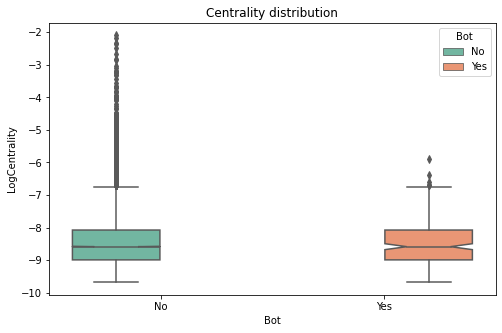

In [0]:
#Distribution of centrality for bot and non bot
plt.figure(figsize = (8,5))
sns.boxplot(data=c, x="Bot", y=np.log(c["Centrality"]),hue=c["Bot"],palette="Set2",notch=True)
plt.title("Centrality distribution")
plt.ylabel("LogCentrality")
plt.show()

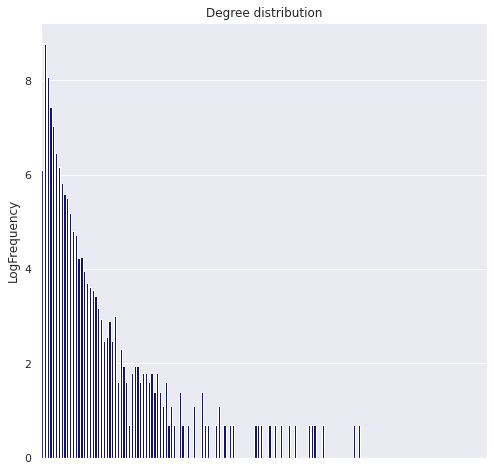

In [0]:
#Degree distribution
degree_distr = pd.DataFrame.from_dict(dict(Counter(degrees)),orient="index",columns=["Freq"])
degree_distr.sort_values('Freq',ascending=False,inplace=True)
degree_distr.reset_index(inplace=True)
degree_distr.columns = ['Degree','Freq']
degree_distr.sort_values('Degree',inplace=True)
sns.set(style="darkgrid")
plt.figure(figsize = (8,8))
dplot = sns.barplot(x="Degree", y=np.log(degree_distr["Freq"]), data=degree_distr,color="darkblue")
plt.xticks([]);plt.xlabel("");plt.ylabel("LogFrequency");plt.title("Degree distribution");plt.savefig("/content/DegreeDistribution.png")

### **Assortativity**

In [0]:
print(f"The assortativity coefficient of the graph (Pearson degree correlation coefficient) is {nx.degree_assortativity_coefficient(g)}.")

The assortativity coefficient of the graph (Pearson degree correlation coefficient) is -0.23302069270194098.


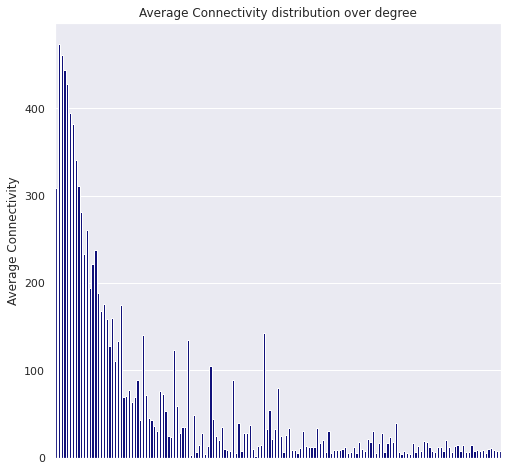

In [0]:
#Average connectivity over degrees
ac = pd.DataFrame.from_dict(dict(nx.average_degree_connectivity(g)),orient="index",columns=["av_connection"])
ac.reset_index(inplace=True)
ac.columns = ['Degree','Average Connectivity']
ac.sort_values('Degree',inplace=True)
sns.set(style="darkgrid")
plt.figure(figsize = (8,8))
dplot = sns.barplot(x="Degree", y='Average Connectivity', data=ac,color="darkblue")
plt.xticks([])
plt.xlabel("")
plt.ylabel("Average Connectivity")
plt.title("Average Connectivity distribution over degree")
plt.savefig("/content/ConnectivityDistribution.png")

### **Core structure: bridges**

In [0]:
##Bridges

#Check if graph has bridges
if nx.has_bridges(g):
    print("The graph has bridges.")
else:
    print("The graph has no bridges.")

#Extract the bridges
bridges = list(nx.bridges(g))
print(f"The graph has {len(bridges)} bridges, {round((100*len(bridges)/g.number_of_edges()),3)}% of the total.")

The graph has bridges.
The graph has 654 bridges, 1.292% of the total.


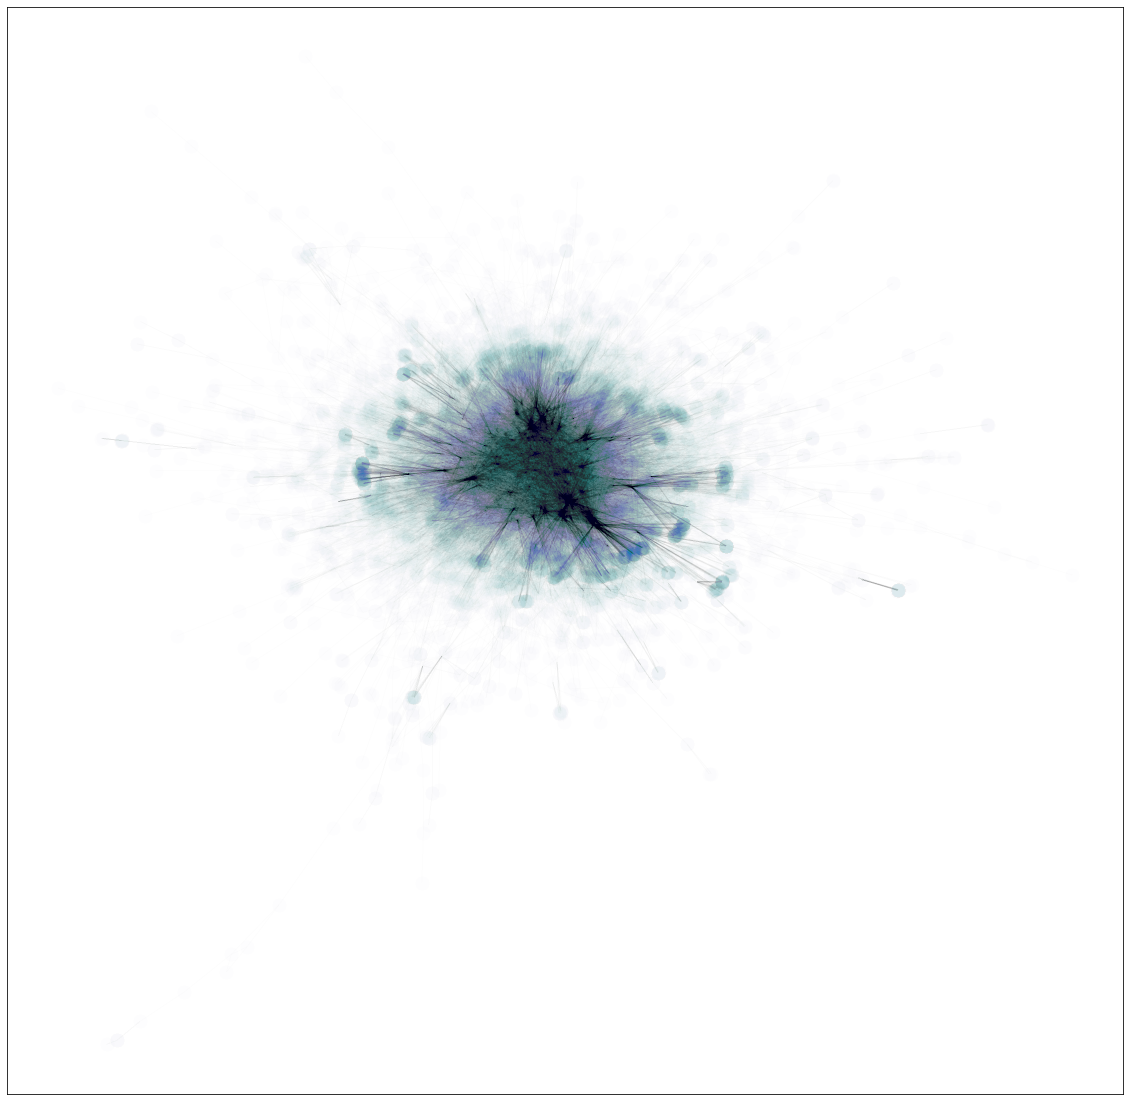

In [0]:
def draw_bridges(g=g,bridge=bridges):
  pos = nx.spring_layout(g)  
  plt.figure(figsize = (20,20))
  nx.draw_networkx(g, pos=pos,alpha=0.007,linewidths=0.01,node_size=200, with_labels=False)
  subgraph = g.subgraph([e for e in set([n for n in bridges])])
  nx.draw_networkx(subgraph, pos=pos,alpha=1, node_color = '#33ff00',node_size=200, with_labels=False)
  plt.savefig("/content/bridges.png")
  plt.show()

draw_bridges()

### **Core structure: cliques**

In [0]:
print(f"There are {nx.graph_number_of_cliques(g)} maximal cliques in the graph.")
print(f"The size of the largest clique in the graph is {nx.graph_clique_number(g)}.")

There are 38435 maximal cliques in the graph.
The size of the largest clique in the graph is 9.


### **Core structure: dominating set**

####1. Extract the set approximating the minimum weight node dominating set.

A dominating set for an undirected graph G with vertex set V and edge set E is a subset D of V such that every vertex not in D is adjacent to at least one member of D.

In [0]:
dom = min_weighted_dominating_set(g)
print(f"The order of the dominating set is {len(dom)} nodes.")
print(f"The dominating set is composed by {len([n for n in dom if n in set(db[db.IsBot==1]['User'])])} bot, {round(100*len([n for n in dom if n in set(db[db.IsBot==1]['User'])])/len(dom),3)}% of the total.")

The order of the dominating set is 3264 nodes.
The dominating set is composed by 34 bot, 1.042% of the total.


In [0]:
#List of dominant bot
dom_bot = [n for n in dom if n in set(db[db.IsBot==1]['User'])]

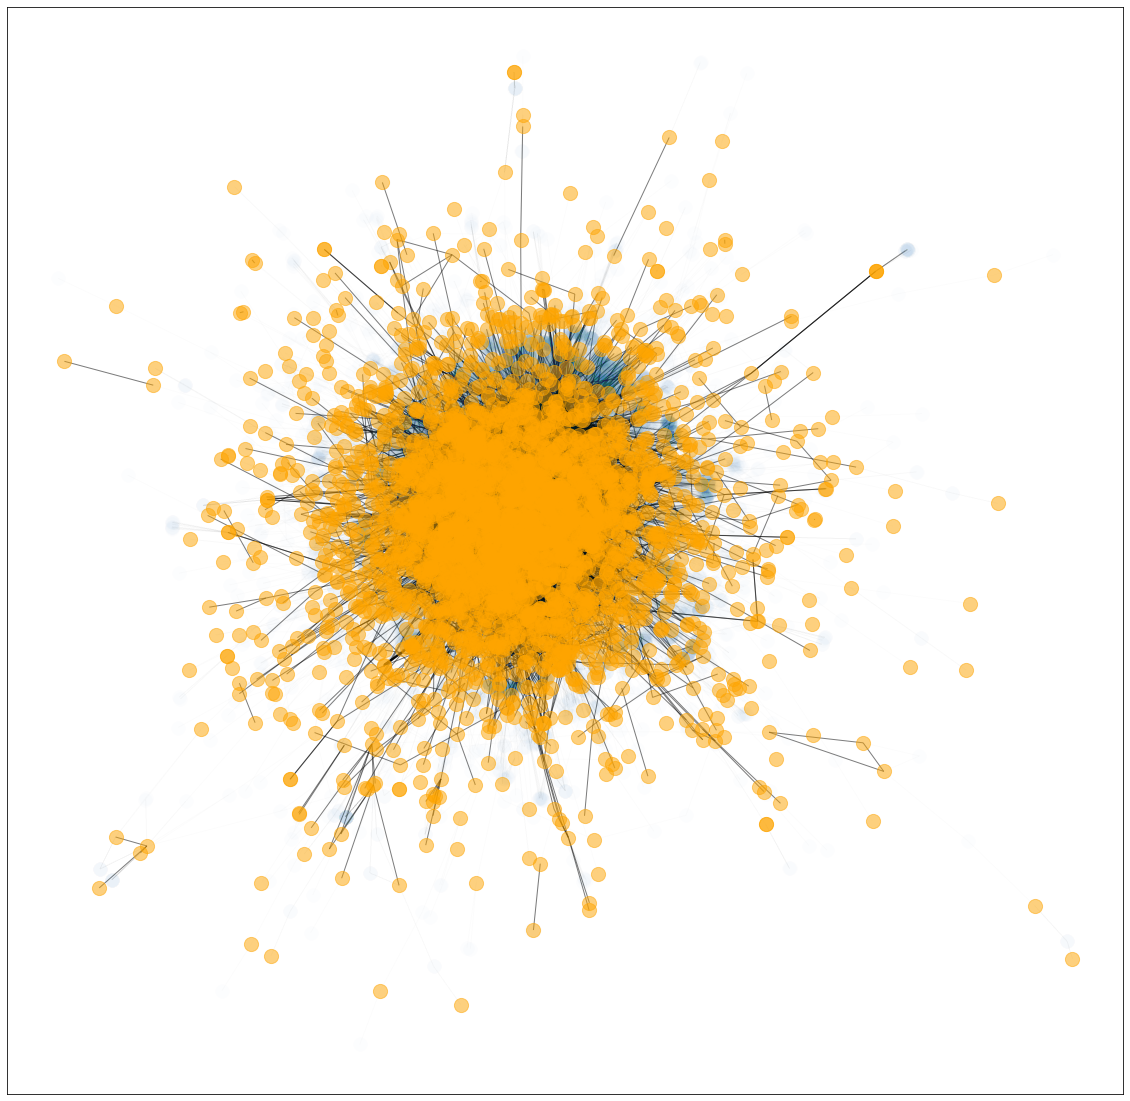

In [0]:
def draw_dominant(g=g):
  pos = nx.spring_layout(g)  
  plt.figure(figsize = (20,20))
  nx.draw_networkx(g, pos=pos,alpha=0.01,linewidths=0.01,node_size=200, with_labels=False)
  subgraph = g.subgraph([n for n in dom])
  nx.draw_networkx(subgraph, pos=pos,alpha=0.5, node_color = 'orange',node_size=200, with_labels=False)
  plt.savefig("/content/dominant.png")
  plt.show()

draw_dominant()

####2. Extract the minimum cardinality edge dominating set.

An edge dominating set is a subset F of E such that every edge not in F is incident to an endpoint of at least one edge in F.

In [0]:
edge_dom = min_edge_dominating_set(g)
print(f"The order of the edge dominating set is {len(edge_dom)} nodes.")
print(f"The edge dominating set is composed by {len([n for n in edge_dom if n in set(db[db.IsBot==1]['User'])])} bot, {round(100*len([n for n in edge_dom if n in set(db[db.IsBot==1]['User'])])/len(edge_dom),3)}% of the total.")

The order of the edge dominating set is 2853 nodes.
The edge dominating set is composed by 0 bot, 0.0% of the total.


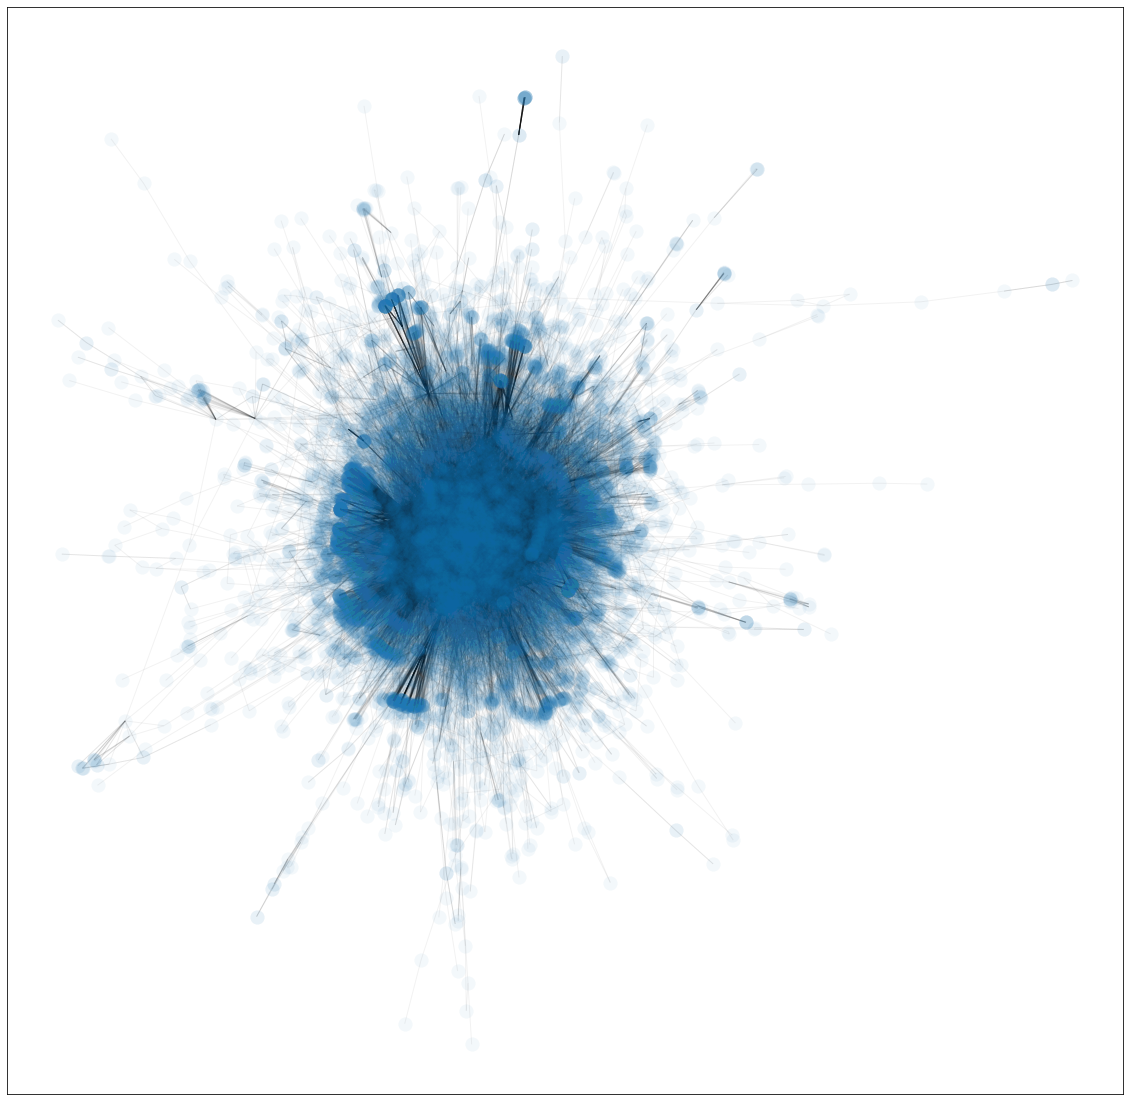

In [0]:
def draw_edge_dominant(g=g):
  pos = nx.spring_layout(g)  
  plt.figure(figsize = (20,20))
  nx.draw_networkx(g, pos=pos,alpha=0.05,linewidths=0.01,node_size=200, with_labels=False)
  subgraph = g.subgraph([n for n in edge_dom])
  nx.draw_networkx(subgraph, pos=pos, node_color = '#6f00ff',node_size=200, with_labels=False)
  plt.savefig("/content/edgedominant.png")
  plt.show()


draw_edge_dominant()

### **Bot SubGraph**

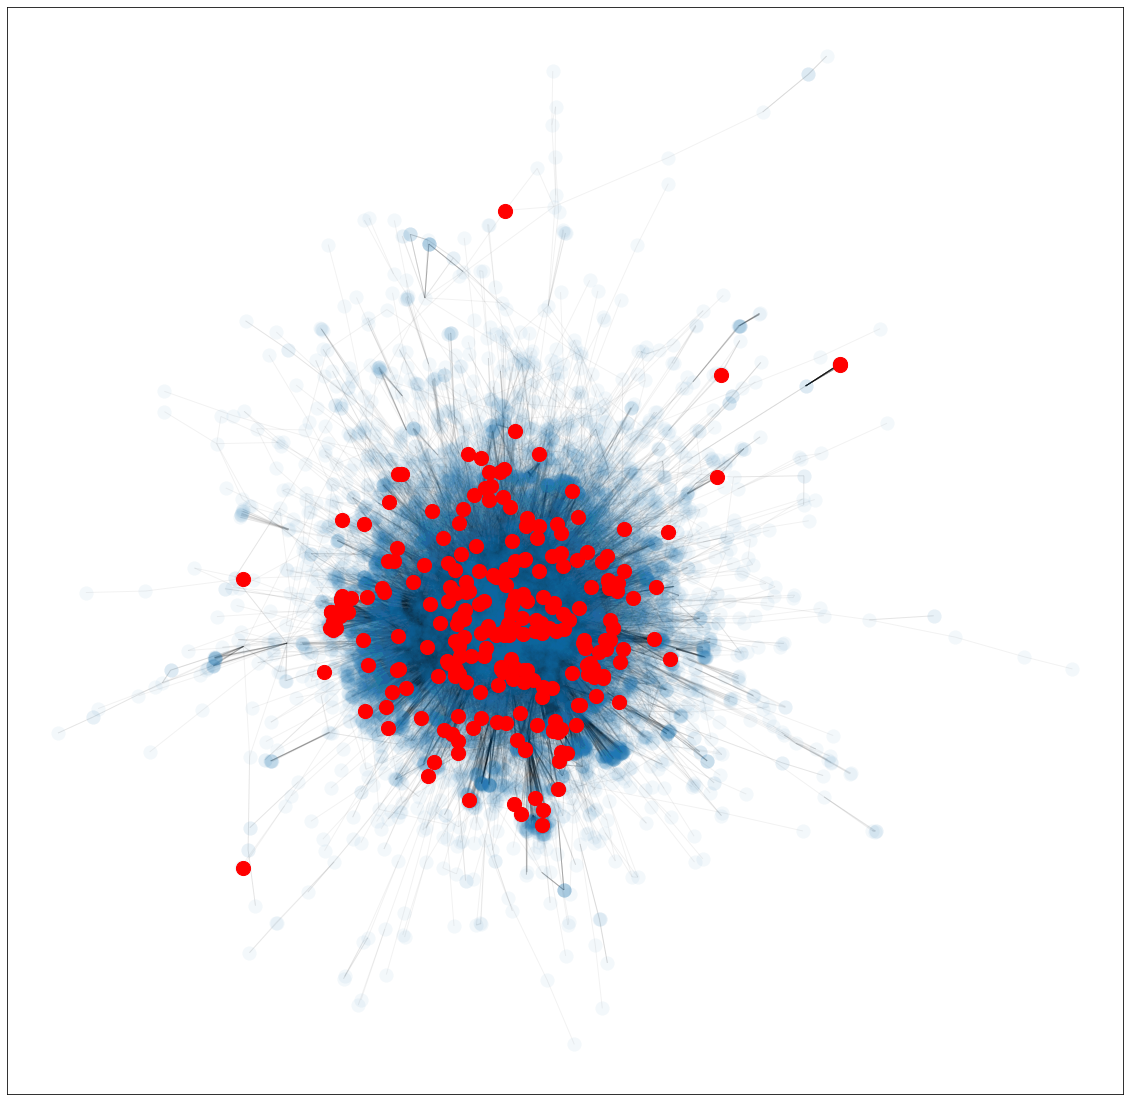

In [0]:
#Extract subgraph of bots
g_bot = g.subgraph([n for n in g if n in set(db[db.IsBot==1]['User'])])
#Plot graph
def draw_bot(g=g):
  pos = nx.spring_layout(g)  
  plt.figure(figsize = (20,20))
  nx.draw_networkx(g, pos=pos,alpha=0.05,linewidths=0.01,node_size=200, with_labels=False)
  subgraph = g.subgraph(set(db[db.IsBot==1]['User']))
  nx.draw_networkx(subgraph, pos=pos, node_color = 'r',node_size=200, with_labels=False)
  plt.savefig("/content/bots.png")
  plt.show()

draw_bot()

In [0]:
print(f"There are {g_bot.number_of_nodes()} nodes and {g_bot.number_of_edges()} edges present in the bots subgraph")
degrees = [val for (node, val) in g_bot.degree()]
print(f"The maximum degree of the subgraph is {np.max(degrees)}")   
print(f"The minimum degree of the subgraph is {np.min(degrees)}")
print(f"The average degree in the subgraph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree in the subgraph is {stats.mode(degrees)}")
if nx.is_connected(g_bot):
    print("The bots subgraph is connected")
else:
    print("The bots subgraph is not connected")
print(f"The average clustering coefficient is {nx.average_clustering(g_bot)}.")
print(f"The transitivity is {nx.transitivity(g_bot)}.")

There are 248 nodes and 9 edges present in the bots subgraph
The maximum degree of the subgraph is 3
The minimum degree of the subgraph is 0
The average degree in the subgraph is 0.1
The most frequent degree in the subgraph is 0
The bots subgraph is not connected
The average clustering coefficient is 0.0.
The transitivity is 0.


______________________________________________________________________________________________________________________
## **Community detection**

###**Louvain's algorithm**

Based on Louvain's heuristics for modularity maximization.

[Link to the documentation.](https://python-louvain.readthedocs.io/en/latest/api.html)

In [5]:
partition = community.best_partition(g)
print(f"The modularity is {community.modularity(partition,g)}.")
print(f"Louvain's algorithm partitioned the graph into {len(set([c for c in partition.values()]))} communities.")

The modularity is 0.5756462107467964.
Louvain's algorithm partitioned the graph into 45 communities.


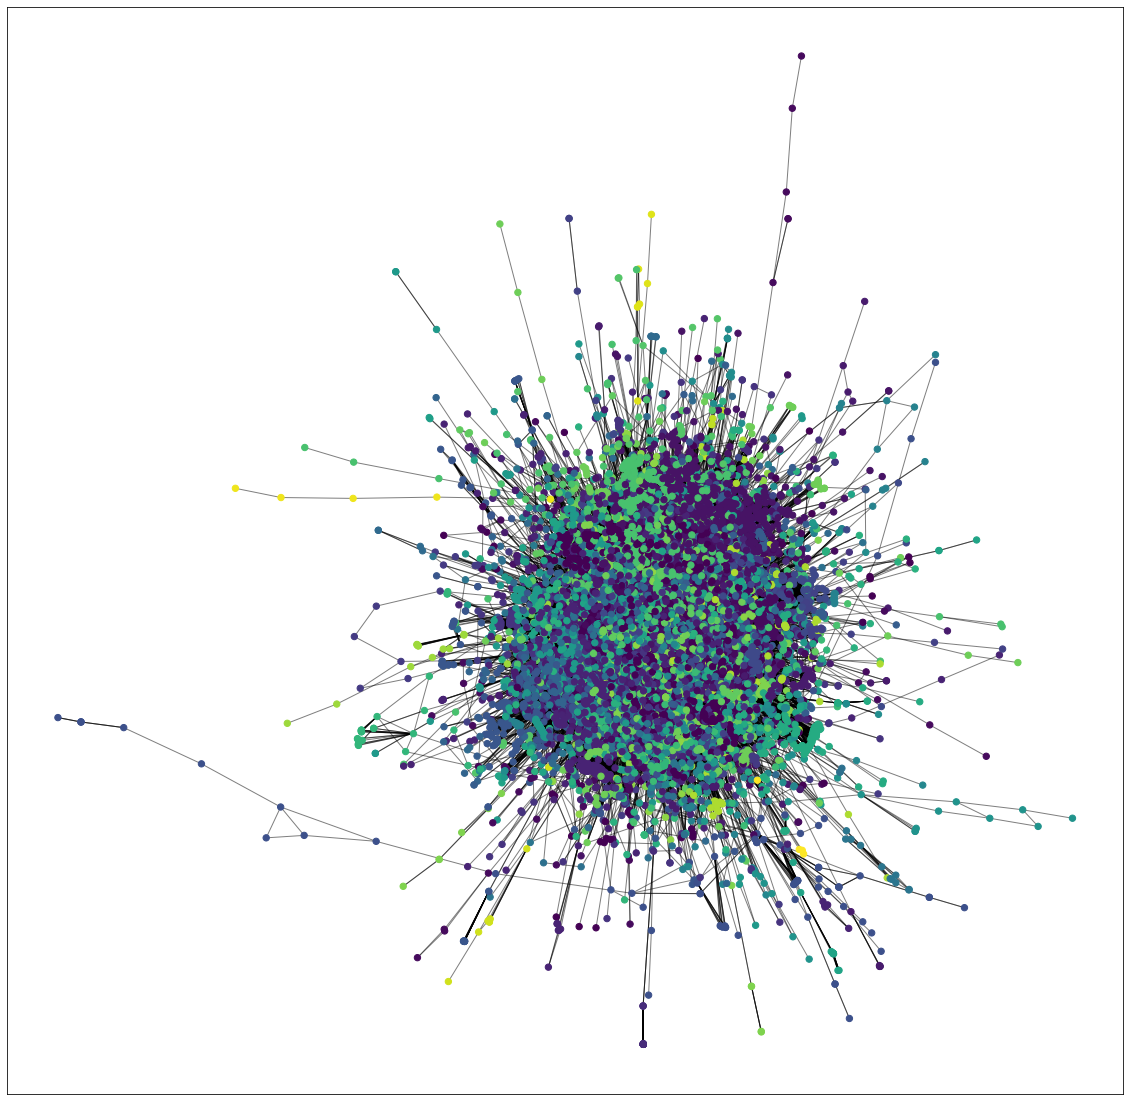

In [0]:
#Draw the partition
def draw_partition(f,g=g,partition=partition):
  pos = nx.spring_layout(g)
  cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
  plt.figure(figsize = (20,20))
  nx.draw_networkx_nodes(g, pos, partition.keys(), node_size=40,cmap=cmap, node_color=list(partition.values()))
  nx.draw_networkx_edges(g, pos, alpha=0.5)
  filename = "/content/"+str(f)+".png"
  plt.savefig(filename)
  plt.show()

draw_partition(f="louvain")

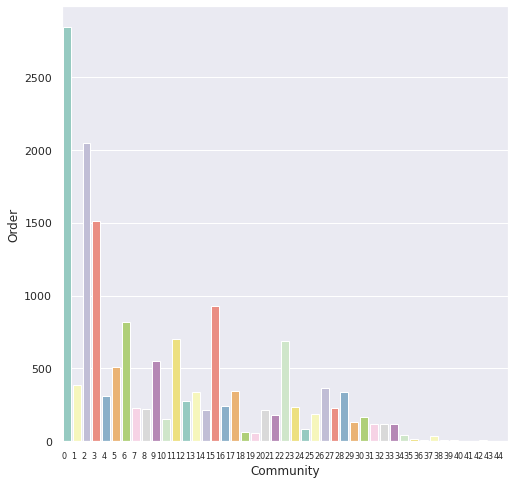

In [17]:
#Convert communities to list of nodes and count
partition_set = defaultdict(list) 
for key, val in sorted(partition.items()): 
    partition_set[val].append(key) 
dim = []
for c in range(len(partition_set)):
  dim.append(len(partition_set[c]))
L = pd.DataFrame(pd.Series(dim))
L.reset_index(inplace=True)
L.columns = ["Community","Order"]
L.sort_values("Order",ascending=False,inplace=True)
sns.set(style="darkgrid")
plt.figure(figsize = (8,8))
dplot = sns.barplot(x="Community", y='Order', data=L,palette="Set3")
plt.xticks(horizontalalignment='right',fontsize=8)
plt.xlabel("Community")
plt.ylabel("Order")
plt.savefig("/content/OrderLouvain.png")

In [8]:
#Compute partition coverage
print(f"The coverage ratio of Louvain's algorithm is {nx.algorithms.community.quality.coverage(g,[e for e in partition_set.values()])}.")

The coverage ratio of Louvain's algorithm is 0.6645860904260572.


### **Newman's method**

Recursive divisive algorithm based on leading eigenvector method: splits maximize the modularity of the original network.

[Link to the documentation.](https://igraph.org/python/doc/igraph.Graph-class.html#community_leading_eigenvector)

In [0]:
#Load graph with igraph package
nx.write_graphml(g,'/content/G.graphml')
G = ig.read('/content/G.graphml',format="graphml")

In [0]:
#Detect communities
c = G.community_leading_eigenvector()
print(f"Newman's method partitioned the graph into {len(c)} communities.")

Newman's method partitioned the graph into 36 communities.


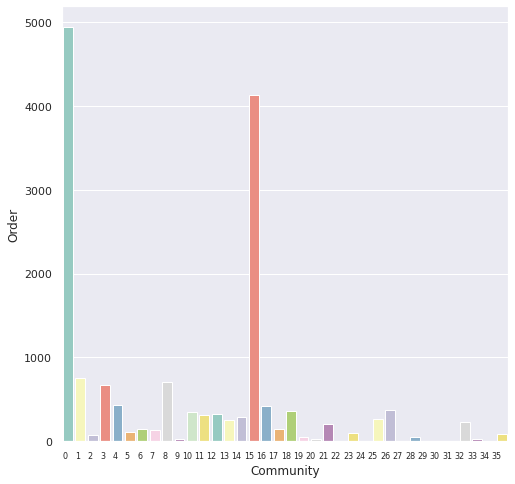

In [0]:
partition_n = c.membership
N = pd.DataFrame.from_dict(dict(Counter(partition_n)),orient="index")
N.reset_index(inplace=True)
N.columns = ['Community','Order']
sns.set(style="darkgrid")
plt.figure(figsize = (8,8))
dplot = sns.barplot(x="Community", y='Order', data=N,palette="Set3")
plt.xticks(horizontalalignment='right',fontsize=8)
plt.xlabel("Community")
plt.ylabel("Order")
plt.savefig("/content/OrderNewman.png")

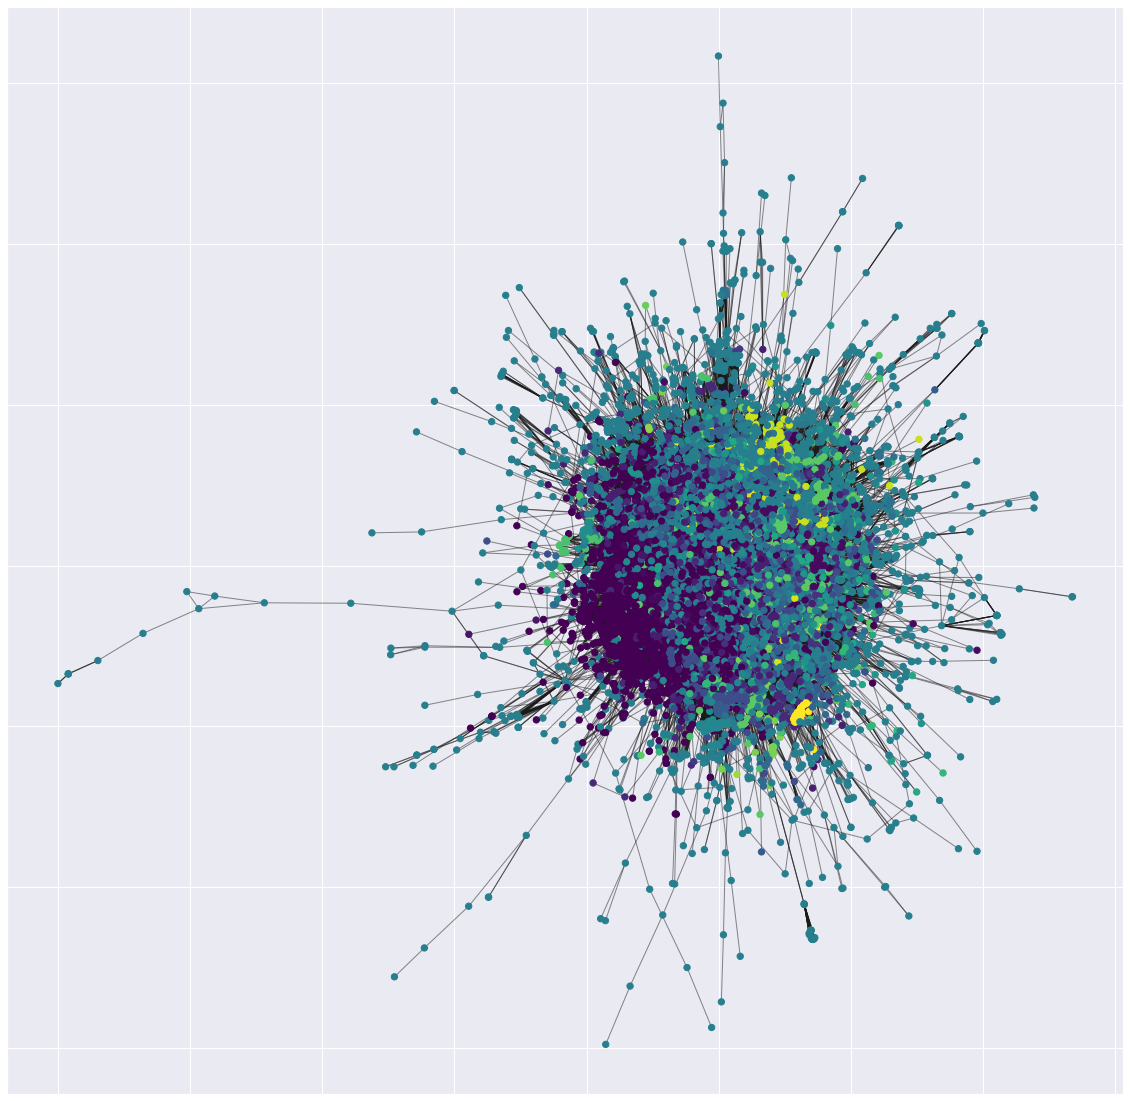

In [0]:
#Convert membership to set of nodes
nodes = [n for n in g]
newman_set = dict(zip(nodes, partition_n))
#Draw partition
draw_partition(f="Newman",partition=newman_set)

In [0]:
#Convert communities to list of nodes and count
newman_partition_set = defaultdict(list) 
for key, val in sorted(newman_set.items()): 
    newman_partition_set[val].append(key)
#Compute partition coverage
print(f"The coverage ratio of Newman's algorithm is {nx.algorithms.community.quality.coverage(g,[e for e in newman_partition_set.values()])}.")

The coverage ratio of Louvain's algorithm is 0.5394947360104292.


###**Asynchronous Label Propagation**

Near linear time probabilistic algorithm to detect community structures in large-scale networks.

[Link to the documentation.](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.label_propagation.asyn_lpa_communities.html#id3)

In [0]:
partition_alp = list(nx.algorithms.community.label_propagation.asyn_lpa_communities(g))
print(f"ALP method partitioned the graph into {len(partition_alp)} communities.")

ALP method partitioned the graph into 1551 communities.


In [0]:
##Filter communities
dim = []
for c in partition_alp:
  dim.append(len(c))
ALP = pd.DataFrame(pd.Series(dim))
ALP.reset_index(inplace=True)
ALP.columns = ["Community","Order"]
ALP.sort_values("Order",ascending=False,inplace=True)
#Filter only communities with order > average order over all the communities
order_mean = np.mean(ALP.Order)
ALP = ALP[ALP.Order>order_mean]
#Double filter
order_mean = np.mean(ALP.Order)
ALP = ALP[ALP.Order>order_mean]
print(f"Number of filtered communities: {len(ALP)}.")
alp_communities = ALP.Community.to_list()
partition_alp_filtered = {}
for c in alp_communities:
  partition_alp_filtered[c]=partition_alp[c]

Number of filtered communities: 33.


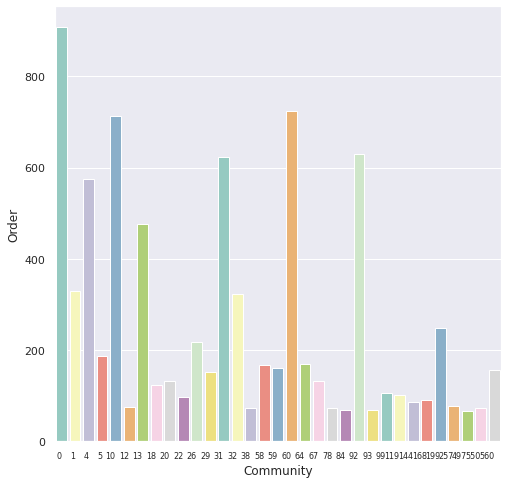

In [0]:
sns.set(style="darkgrid")
plt.figure(figsize = (8,8))
dplot = sns.barplot(x="Community", y='Order', data=ALP,palette="Set3")
plt.xticks(horizontalalignment='right',fontsize=8)
plt.xlabel("Community")
plt.ylabel("Order")
plt.savefig("/content/OrderALP.png")

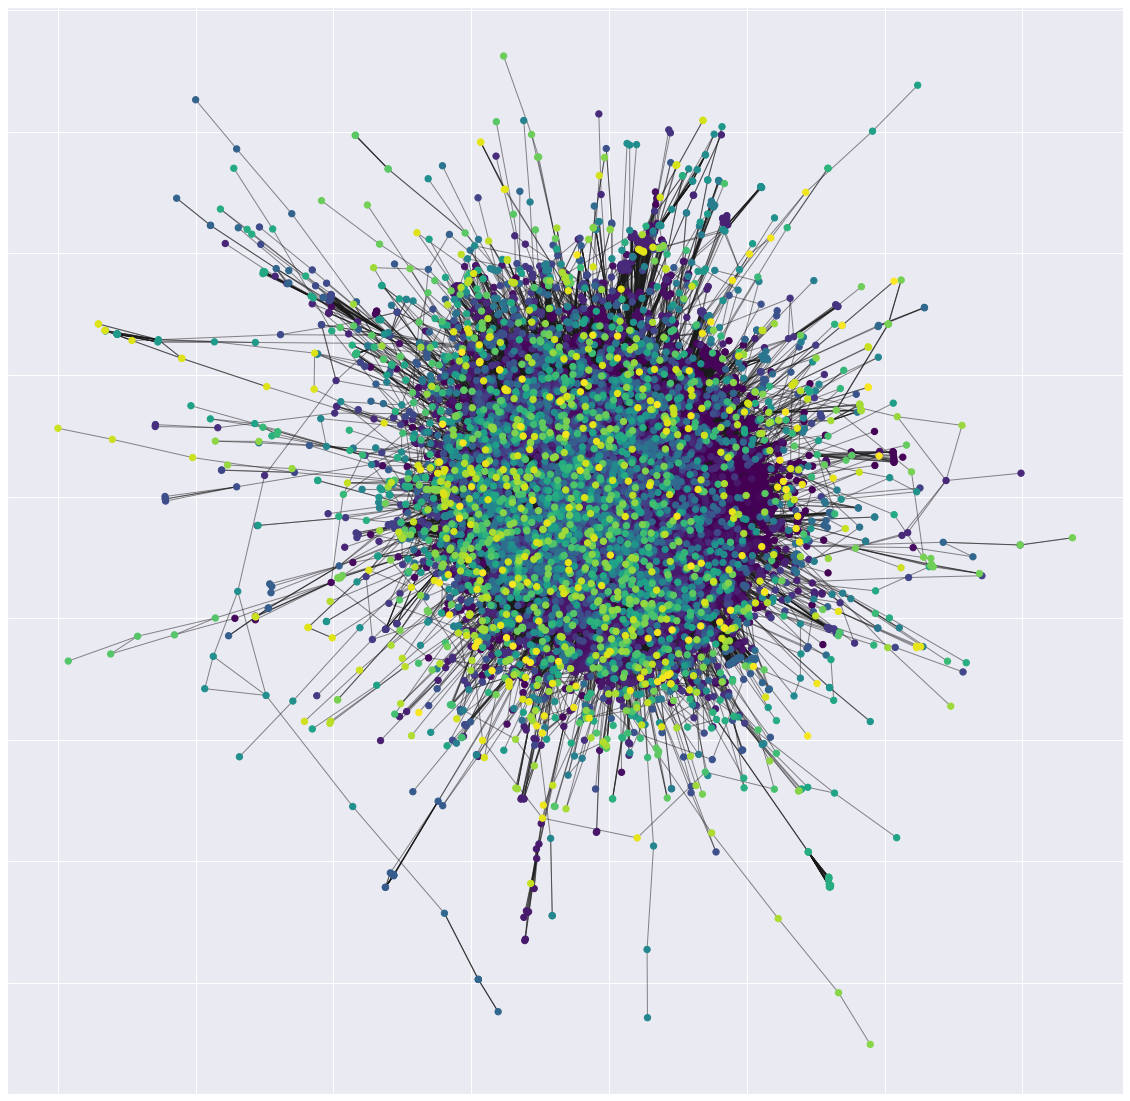

In [0]:
#Covert set to membership
alp = dict(zip(range(len([e for e in partition_alp])), [e for e in partition_alp]))
alp_membership = {}
for k,v in alp.items():
  for e in v:
    alp_membership[e] = k
#Draw partition
draw_partition(f="apl",partition=alp_membership)

In [0]:
#Compute partition coverage
print(f"The coverage ratio of ALP algorithm is {nx.algorithms.community.quality.coverage(g,partition_alp)}.")

The coverage ratio of ALP algorithm is 0.4770774487921465.


### **Information Map method**

This algorithm finds the community structure of the network according to the InfoMap method by Rosvall and Bergstrom.

[Link to the documentation.](https://igraph.org/python/doc/igraph.Graph-class.html#community_infomap)

In [9]:
#Detect communities
c = G.community_infomap()
print(f"InfoMap method partitioned the graph into {len(c)} communities.")

InfoMap method partitioned the graph into 853 communities.


Number of filtered communities: 34.


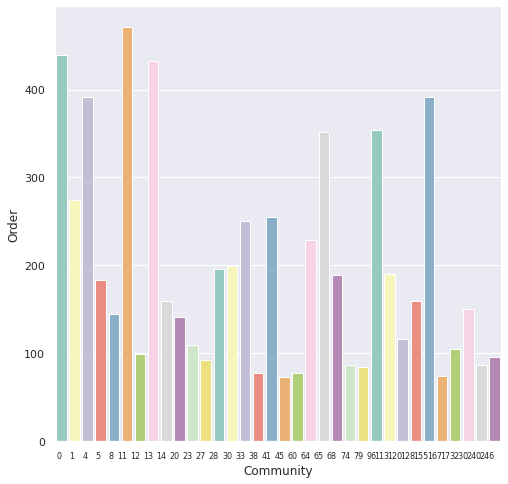

In [12]:
partition_infomap = c.membership
IM = pd.DataFrame.from_dict(dict(Counter(partition_infomap)),orient="index")
IM.reset_index(inplace=True)
IM.columns = ['Community','Order']
#Filter only communities with order > average order over all the communities
order_mean = np.mean(IM.Order)
IM = IM[IM.Order>order_mean]
#Double filter
order_mean = np.mean(IM.Order)
IM = IM[IM.Order>order_mean]
print(f"Number of filtered communities: {len(IM)}.")
sns.set(style="darkgrid")
plt.figure(figsize = (8,8))
dplot = sns.barplot(x="Community", y='Order', data=IM,palette="Set3")
plt.xticks(horizontalalignment='right',fontsize=8)
plt.xlabel("Community")
plt.ylabel("Order")
plt.savefig("/content/OrderIM.png")

In [0]:
#Convert membership to set of nodes
im_set = dict(zip(nodes, partition_infomap))
#Draw partition
draw_partition(f="Edge",partition=edge_set)

In [15]:
#Convert communities to list of nodes and count
im_partition_set = defaultdict(list) 
for key, val in sorted(im_set.items()): 
    im_partition_set[val].append(key)
#Compute partition coverage
print(f"The coverage ratio of InfoMap method is {nx.algorithms.community.quality.coverage(g,[e for e in im_partition_set.values()])}.")

The coverage ratio of InfoMap method is 0.52333734963557.


Final results:

In [9]:
a = ['Louvain',45,0.6645860904260572]
b = ['Newman',36,0.5394947360104292]
c = ['ALP',1551,0.4770774487921465]
d = ['InfoMap',853,0.52333734963557]
abcd = pd.DataFrame([a,b,c,d],columns = [" ",'Partition','Coverage'])
abcd.set_index(" ",inplace=True)
abcd.sort_values('Coverage',ascending=False,inplace=True)
abcd

Partition  Coverage
                            
Louvain         45  0.664586
Newman          36  0.539495
InfoMap        853  0.523337
ALP           1551  0.477077

The partition derived from **Louvain's algorithm** is selected, because it offers the best perfomance measure, namely the highest coverage ration value.

In [19]:
#Filter only the communities with order grater than mean
av_order = np.mean(L.Order)
print(f"The average community order in the selected partition is {av_order}.")
#Select only relevant communities
L = L[L.Order>av_order]
print(f"The number of relevant communities is {len(L)}.")
print("Relevant communities"+"\n")
display(L)

The average community order in the selected partition is 356.9111111111111.
The number of relevant communities is 11.
Relevant communities



Community  Order
0           0   2841
2           2   2048
3           3   1509
15         15    928
6           6    818
11         11    703
22         22    686
9           9    552
5           5    513
1           1    388
26         26    366

In [90]:
#Create subpartition
p = {k: partition_set[k] for k in L.Community}
#Function to extract key
def find(search,d=p):
  if [k for k, v in d.items() if search in v]:
    return str(int([k for k, v in d.items() if search in v][0]))
  else:
    return np.nan
#Apply to db
part = []
for i in range(len(db)):
    part.append(find(db.loc[i]['User']))
db['Community'] = part
print(f"The number of tweet originated from a relevant community is {len(db[pd.notna(db.Community)])}.")
print(f"The total number of nodes from relevant communities is {len([n for n in g if [k for k, v in p.items() if n in v]])}, {100*len([n for n in g if [k for k, v in p.items() if n in v]])/len([n for n in g])}% of the total.")

The number of tweet originated from a relevant community is 25917.
The total number of nodes from relevant communities is 11352, 70.68053047755433% of the total.


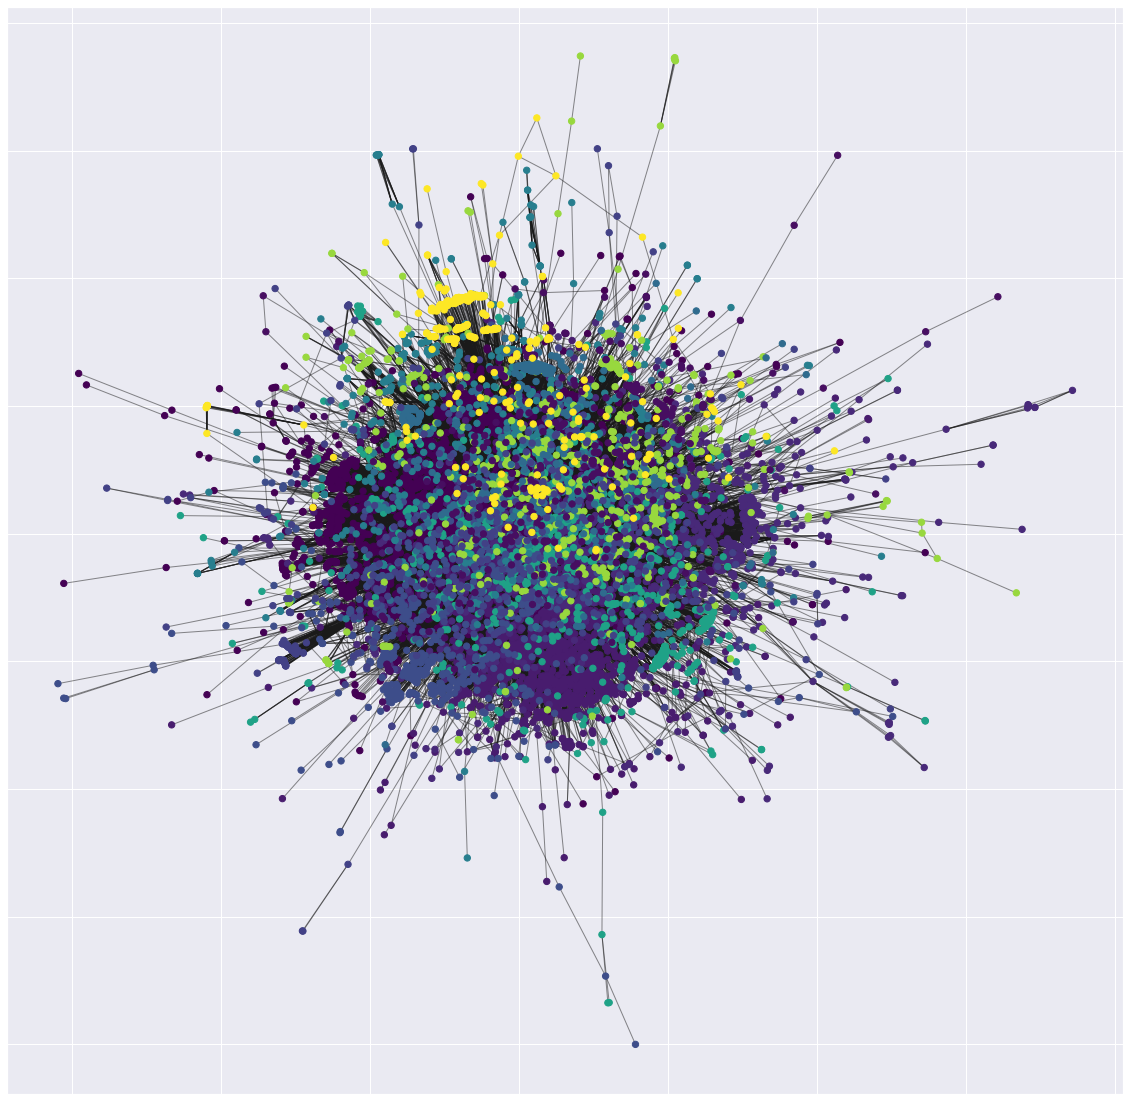

In [135]:
#Extract subpartition
pp = {}
for k,v in p.items():
  for e in v:
    pp[e] = k
#Extract subgraph
gp = g.subgraph([n for n in g if n in pp.keys()])
#Draw
draw_partition(f="partition",g=gp,partition=pp)

______________________________________________________________________________________________________________________
## **Community analysis**


-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-
